In [1]:
# credit to the following notebooks
#https://www.kaggle.com/dschettler8845/bms-efficientnetv2-tpu-e2e-pipeline-in-3hrs
#https://www.kaggle.com/yihdarshieh/detailed-guide-to-custom-training-with-tpus
#https://www.kaggle.com/markwijkhuizen/tensorflow-tpu-training-baseline-lb-16-92/comments

In [2]:
# Installs
print("\n... PIP/APT INSTALLS STARTING ...\n")
# Pips
!pip install -q --upgrade pip
!pip install -q pydot
!pip install -q pydotplus
!pip install -q neptune-notebooks
!pip install -q neptune-client

# Apt-get
!apt-get install -q graphviz
print("\n... PIP/APT INSTALLS COMPLETE ...\n")

print("\n... IMPORTS STARTING ...\n")
print("\n\tVERSION INFORMATION")
# Machine Learning and Data Science Imports
import tensorflow as tf; print(f"\t\t– TENSORFLOW VERSION: {tf.__version__}");
import tensorflow_addons as tfa; print(f"\t\t– TENSORFLOW ADDONS VERSION: {tfa.__version__}");
import pandas as pd; pd.options.mode.chained_assignment = None;
import numpy as np; print(f"\t\t– NUMPY VERSION: {np.__version__}");

# Library used to easily calculate LD
import Levenshtein

# Built In Imports
from kaggle_datasets import KaggleDatasets
from collections import Counter
from datetime import datetime
from glob import glob
import warnings
import requests
import imageio
import IPython
import urllib
import zipfile
import pickle
import random
import shutil
import string
import math
import time
import gzip
import ast
import sys
import io
import os
import gc
import re

# Visualization Imports
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm; tqdm.pandas();
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib; print(f"\t\t– MATPLOTLIB VERSION: {matplotlib.__version__}");
import plotly
import PIL
import cv2


def seed_it_all(seed=42):
    """ Attempt to be Reproducible """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    
print("\n\n... IMPORTS COMPLETE ...\n")
    
print("\n... SEEDING FOR DETERMINISTIC BEHAVIOUR ...\n")
seed_it_all()

# To give access to automl files
sys.path.append("/kaggle/input/automl-efficientdet-efficientnetv2/automl")
sys.path.append("/kaggle/input/automl-efficientdet-efficientnetv2/automl/brain_automl")
sys.path.append("/kaggle/input/automl-efficientdet-efficientnetv2/automl/brain_automl/efficientnetv2")


... PIP/APT INSTALLS STARTING ...

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.

... PIP/APT INSTALLS COMPLETE ...


... IMPORTS STARTING ...


	VERSION INFORMATION
		– TENSORFLOW VERSION: 2.4.1
		– TENSORFLOW ADDONS VERSION: 0.12.1
		– NUMPY VERSION: 1.19.5
		– MATPLOTLIB VERSION: 3.4.1


... IMPORTS COMPLETE ...


... SEEDING FOR DETERMINISTIC BEHAVIOUR ...



In [3]:
GCS_CHECKPOINT_PATH = KaggleDatasets().get_gcs_path('efficientnetv2-tf-checkpoints')
print(GCS_CHECKPOINT_PATH)

gs://kds-fe38ac61cd34692e7b56b9ad4fcc2fa1467d59671e9d235923de17d8


In [4]:
#!gsutil ls $GCS_PATH

In [5]:
# For reference later
EV2_NAME = "efficientnetv2-b3"
    
# EfficientNet Module Imports
import brain_automl
from brain_automl import efficientnetv2
from efficientnetv2 import effnetv2_model
from efficientnetv2 import effnetv2_configs

# See EfficientNetV2 Base Config
for k,v in  efficientnetv2.hparams.base_config.items(): print(k,v)

model act_fn: silu
blocks_args: null
bn_epsilon: 0.001
bn_momentum: 0.9
bn_type: null
conv_dropout: null
data_format: channels_last
depth_coefficient: null
depth_divisor: 8
dropout_rate: null
feature_size: 1280
gn_groups: 8
headbias: null
local_pooling: false
min_depth: 8
model_name: efficientnet-b0
num_classes: 1000
survival_prob: 0.8
width_coefficient: null

train batch_size: 4096
ema_decay: 0.9999
epochs: 350
ft_init_ckpt: null
ft_init_ema: true
gclip: 0
isize: null
label_smoothing: 0.1
loss_type: null
lr_base: 0.016
lr_decay_epoch: 2.4
lr_decay_factor: 0.97
lr_min: 0
lr_sched: exponential
lr_warmup_epoch: 5
min_steps: 0
optimizer: rmsprop
sched: null
split: null
stages: 0
varsexp: null
weight_decay: 1.0e-05
weight_decay_exclude: .*(bias|gamma|beta).*
weight_decay_inc: 0.0

eval batch_size: 8
isize: null
split: null

data augname: randaug
cache: true
cutmix_alpha: 0.0
data_dir: null
ds_name: imagenet
ibase: 128
mixup_alpha: 0.0
multiclass: null
num_classes: 1000
ra_num_layers: 2
ram

In [6]:
print(f"\n... ACCELERATOR SETUP STARTING ...\n")

# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  
except ValueError:
    TPU = None

if TPU:
    print(f"\n... RUNNING ON TPU - {TPU.master()}...")
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.TPUStrategy(TPU)
else:
    print(f"\n... RUNNING ON CPU/GPU ...")
    # Yield the default distribution strategy in Tensorflow
    #   --> Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy() 

N_REPLICAS = strategy.num_replicas_in_sync
    
print(f"... # OF REPLICAS: {N_REPLICAS} ...\n")

print(f"\n... ACCELERATOR SETUP COMPLTED ...\n")


... ACCELERATOR SETUP STARTING ...


... RUNNING ON TPU - grpc://10.0.0.2:8470...
... # OF REPLICAS: 8 ...


... ACCELERATOR SETUP COMPLTED ...



In [7]:
print("\n... DATA ACCESS SETUP STARTED ...\n")

if TPU:
    # Google Cloud Dataset path to training and validation images
    TEST_DATA_DIR = KaggleDatasets().get_gcs_path('bms-test-dataset-192x384')
else:
    # Local path to training and validation images
    TEST_DATA_DIR = "../input/bms-test-dataset-192x384"
    
print(f"... TEST DATA DIRECTORY PATH IS:\n\t--> {TEST_DATA_DIR}")

print(f"... IMMEDIATE CONTENTS OF TEST DATA DIRECTORY IS:")
for file in tf.io.gfile.glob(os.path.join(TEST_DATA_DIR, "*")): print(f"\t--> {file}")

    
print("\n\n... DATA ACCESS SETUP COMPLETED ...\n")


... DATA ACCESS SETUP STARTED ...

... TEST DATA DIRECTORY PATH IS:
	--> gs://kds-df022f5e8ac369e87c52294e427a2d0d87d07162f7685d942c513e42
... IMMEDIATE CONTENTS OF TEST DATA DIRECTORY IS:
	--> gs://kds-df022f5e8ac369e87c52294e427a2d0d87d07162f7685d942c513e42/test_records


... DATA ACCESS SETUP COMPLETED ...



In [8]:
print(f"\n... MIXED PRECISION SETUP STARTING ...\n")
print("\n... SET TF TO OPERATE IN MIXED PRECISION – `bfloat16` – IF ON TPU ...")

tf.keras.mixed_precision.set_global_policy('mixed_bfloat16' if TPU else 'float32')

# target data type, bfloat16 when using TPU to improve throughput
TARGET_DTYPE = tf.bfloat16 if TPU else tf.float32
print(f"\t--> THE TARGET DTYPE HAS BEEN SET TO {TARGET_DTYPE} ...")

print(f"\n... TWO IMPORTANT ASPECTS OF THE GLOBAL MIXED PRECISION POLICY:")
print(f'\t--> COMPUTE DTYPE  : {tf.keras.mixed_precision.global_policy().compute_dtype}')
print(f'\t--> VARIABLE DTYPE : {tf.keras.mixed_precision.global_policy().variable_dtype}')

print(f"\n\n... MIXED PRECISION SETUP COMPLTED ...\n")


... MIXED PRECISION SETUP STARTING ...


... SET TF TO OPERATE IN MIXED PRECISION – `bfloat16` – IF ON TPU ...
	--> THE TARGET DTYPE HAS BEEN SET TO <dtype: 'bfloat16'> ...

... TWO IMPORTANT ASPECTS OF THE GLOBAL MIXED PRECISION POLICY:
	--> COMPUTE DTYPE  : bfloat16
	--> VARIABLE DTYPE : float32


... MIXED PRECISION SETUP COMPLTED ...



In [9]:
print(f"\n... XLA OPTIMIZATIONS STARTING ...\n")

print(f"\n... CONFIGURE JIT (JUST IN TIME) COMPILATION ...\n")
# enable XLA optmizations (10% speedup when using @tf.function calls)
tf.config.optimizer.set_jit(True)

print(f"\n... XLA OPTIMIZATIONS COMPLETED ...\n")


... XLA OPTIMIZATIONS STARTING ...


... CONFIGURE JIT (JUST IN TIME) COMPILATION ...


... XLA OPTIMIZATIONS COMPLETED ...



In [10]:
print("\n... BASIC DATA SETUP STARTING ...\n")

# All the possible tokens in our InChI 'language'
TOKEN_LIST = ["<PAD>", "InChI=1S/", "<END>", "/c", "/h", "/m", "/t", "/b", "/s", "/i"] +\
             ['Si', 'Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'C', 'H', 'B', ] +\
             [str(i) for i in range(167,-1,-1)] +\
             ["\+", "\(", "\)", "\-", ",", "D", "T"]
print(f"\n... TOKEN LIST:")
for i, tok in enumerate(TOKEN_LIST): print(f"\t--> INTEGER-IDX = {i:<3}  –––  STRING = {tok}")

# The start/end/pad tokens will be removed from the string when computing the Levenshtein distance
# We want them as tf.constant's so they will operate properly within the @tf.function context
START_TOKEN = tf.constant(TOKEN_LIST.index("InChI=1S/"), dtype=tf.uint8)
END_TOKEN = tf.constant(TOKEN_LIST.index("<END>"), dtype=tf.uint8)
PAD_TOKEN = tf.constant(TOKEN_LIST.index("<PAD>"), dtype=tf.uint8)

# Prefixes and Their Respective Ordering/Format
#      -- ORDERING --> {c}{h/None}{b/None}{t/None}{m/None}{s/None}{i/None}{h/None}{t/None}{m/None}
PREFIX_ORDERING = "chbtmsihtm"
print(f"\n... PREFIX ORDERING IS {PREFIX_ORDERING} ...")

# Paths to Respective Image Directories
TEST_DIR = os.path.join(TEST_DATA_DIR, "test_records")

# Get the Full Paths to The Individual TFRecord Files
TEST_TFREC_PATHS = sorted(
    tf.io.gfile.glob(os.path.join(TEST_DIR, "*.tfrec")), 
    key=lambda x: int(x.rsplit("_", 2)[1]))

print(f"\n... TFRECORD INFORMATION:")
for SPLIT, TFREC_PATHS in zip(["TEST"], [TEST_TFREC_PATHS]):
    print(f"\t--> {len(TFREC_PATHS):<3} {SPLIT:<5} TFRECORDS")

# Paths to relevant CSV files containing training and submission information
SS_CSV_PATH    = os.path.join("/kaggle/input", "bms-csvs-w-extra-metadata", "sample_submission_w_extra.csv")
print(f"\n... PATHS TO CSVS:")
print(f"\t--> SS CSV   : {SS_CSV_PATH}")

# When debug is true we use a smaller batch size and smaller model
DEBUG=False

print("\n\n... BASIC DATA SETUP COMPLETED ...\n")


... BASIC DATA SETUP STARTING ...


... TOKEN LIST:
	--> INTEGER-IDX = 0    –––  STRING = <PAD>
	--> INTEGER-IDX = 1    –––  STRING = InChI=1S/
	--> INTEGER-IDX = 2    –––  STRING = <END>
	--> INTEGER-IDX = 3    –––  STRING = /c
	--> INTEGER-IDX = 4    –––  STRING = /h
	--> INTEGER-IDX = 5    –––  STRING = /m
	--> INTEGER-IDX = 6    –––  STRING = /t
	--> INTEGER-IDX = 7    –––  STRING = /b
	--> INTEGER-IDX = 8    –––  STRING = /s
	--> INTEGER-IDX = 9    –––  STRING = /i
	--> INTEGER-IDX = 10   –––  STRING = Si
	--> INTEGER-IDX = 11   –––  STRING = Br
	--> INTEGER-IDX = 12   –––  STRING = Cl
	--> INTEGER-IDX = 13   –––  STRING = F
	--> INTEGER-IDX = 14   –––  STRING = I
	--> INTEGER-IDX = 15   –––  STRING = N
	--> INTEGER-IDX = 16   –––  STRING = O
	--> INTEGER-IDX = 17   –––  STRING = P
	--> INTEGER-IDX = 18   –––  STRING = S
	--> INTEGER-IDX = 19   –––  STRING = C
	--> INTEGER-IDX = 20   –––  STRING = H
	--> INTEGER-IDX = 21   –––  STRING = B
	--> INTEGER-IDX = 22   –––  STRING = 167

In [11]:
print("\n... INITIAL DATAFRAME INSTANTIATION STARTING ...\n")

# Load the train and submission dataframes
ss_df    = pd.read_csv(SS_CSV_PATH)

# --- Distribution Information ---
N_TEST  = len(ss_df)

# --- Batching Information ---
BATCH_SIZE_DEBUG   = 2
REPLICA_BATCH_SIZE = 64 # Could probably be 128
EPOCHS = 15

if DEBUG:
    REPLICA_BATCH_SIZE = BATCH_SIZE_DEBUG
OVERALL_BATCH_SIZE = REPLICA_BATCH_SIZE*N_REPLICAS


# --- Input Image Information ---
IMG_SHAPE = (192,384,3)
HEIGHT, WIDTH  = 192, 384

# --- Autocalculate Training/Validation/Testing Information ---
TEST_STEPS  = int(np.ceil(N_TEST/OVERALL_BATCH_SIZE))

# This is for padding our test dataset so we only have whole batches
REQUIRED_DATASET_PAD = OVERALL_BATCH_SIZE-N_TEST%OVERALL_BATCH_SIZE

# --- Modelling Information ---
ATTN_EMB_DIM  = 192
N_RNN_UNITS   = 512

print(f"... # OF TEST EXAMPLES       : {N_TEST:<7} ...\n")

print(f"\n... REPLICA BATCH SIZE    : {REPLICA_BATCH_SIZE} ...")
print(f"... OVERALL BATCH SIZE    : {OVERALL_BATCH_SIZE} ...\n")

print(f"\n... IMAGE SHAPE           : {IMG_SHAPE} ...\n")

print(f"... TEST STEPS PER EPOCH  : {TEST_STEPS:<5} ...\n")

print(f"\n... ATTENTION EMBEDDING DIMENSION : {ATTN_EMB_DIM:<5} ...")
print(f"... NUMBER OF UNITS IN LSTM       : {N_RNN_UNITS:<5} ...\n")

print("\n... SUBMISSION DATAFRAME ...\n")
display(ss_df.head(3))

print("\n... INITIAL DATAFRAME INSTANTIATION COMPLETED...\n")


... INITIAL DATAFRAME INSTANTIATION STARTING ...

... # OF TEST EXAMPLES       : 1616107 ...


... REPLICA BATCH SIZE    : 64 ...
... OVERALL BATCH SIZE    : 512 ...


... IMAGE SHAPE           : (192, 384, 3) ...

... TEST STEPS PER EPOCH  : 3157  ...


... ATTENTION EMBEDDING DIMENSION : 192   ...
... NUMBER OF UNITS IN LSTM       : 512   ...


... SUBMISSION DATAFRAME ...



,image_id,InChI,img_path,roi_bbox,crop_width,crop_height,aspect_ratio
0,00000d2a601c,InChI=1S/H2O/h1H2,/kaggle/input/bms-molecular-translation/test/0...,"(38, 1, 318, 205)",280,204,1.372549
1,00001f7fc849,InChI=1S/H2O/h1H2,/kaggle/input/bms-molecular-translation/test/0...,"(38, 38, 226, 401)",188,363,0.517906
2,000037687605,InChI=1S/H2O/h1H2,/kaggle/input/bms-molecular-translation/test/0...,"(38, 38, 297, 349)",259,311,0.832797



... INITIAL DATAFRAME INSTANTIATION COMPLETED...



In [12]:
print("\n... SPECIAL VARIABLE SETUP STARTING ...\n")


# Whether to start training using previously checkpointed model
LOAD_MODEL        = False
ENCODER_CKPT_PATH = ""
DECODER_CKPT_PATH = ""

if LOAD_MODEL:
    print(f"\n... ENCODER MODEL TRAINING WILL RESUME FROM PREVIOUS CHECKPOINT:\n\t-->{ENCODER_CKPT_PATH}\n")
    print(f"... DECODER MODEL TRAINING WILL RESUME FROM PREVIOUS CHECKPOINT:\n\t-->{DECODER_CKPT_PATH}\n")
else:
    print(f"\n... MODEL TRAINING WILL START FROM SCRATCH ...\n")

    
print("\n... SPECIAL VARIABLE SETUP COMPLETED ...\n")


... SPECIAL VARIABLE SETUP STARTING ...


... MODEL TRAINING WILL START FROM SCRATCH ...


... SPECIAL VARIABLE SETUP COMPLETED ...



In [13]:
def flatten_l_o_l(nested_list):
    """ Flatten a list of lists """
    return [item for sublist in nested_list for item in sublist]


def tf_load_image(path, img_size=(192,384,3), invert=False):
    """ Load an image with the correct size and shape 
    
    Args:
        path (tf.string): Path to the image to be loaded
        img_size (tuple, optional): Size to reshape image to (required for TPU)
        tile_to_3_channel (bool, optional): Whether to tile the single channel
            image to 3 channels which will be required for most off-the-shelf models
        invert (bool, optional): Whether or not to invert the background/foreground
    
    Returns:
        3 channel tf.Constant image ready for training/inference
    
    """
    img = decode_img(tf.io.read_file(path), img_size, n_channels=3, invert=invert)        
    return img
    
    
def decode_image(image_data, resize_to=(192,384,3)):
    """ Function to decode the tf.string containing image information 
    
    
    Args:
        image_data (tf.string): String containing encoded image data from tf.Example
        resize_to (tuple, optional): Size that we will reshape the tensor to (required for TPU)
    
    Returns:
        Tensor containing the resized single-channel image in the appropriate dtype
    """
    image = tf.image.decode_png(image_data, channels=3)
    image = tf.reshape(image, resize_to)
    return tf.cast(image, TARGET_DTYPE)
    
    
# sparse tensors are required to compute the Levenshtein distance
def dense_to_sparse(dense):
    """ Convert a dense tensor to a sparse tensor 
    
    Args:
        dense (Tensor): TBD
        
    Returns:
        A sparse tensor    
    """
    indices = tf.where(tf.ones_like(dense))
    values = tf.reshape(dense, (MAX_LEN*OVERALL_BATCH_SIZE,))
    sparse = tf.SparseTensor(indices, values, dense.shape)
    return sparse

def get_levenshtein_distance(preds, lbls):
    """ Computes the Levenshtein distance between the predictions and labels 
    
    Args:
        preds (tensor): Batch of predictions
        lbls (tensor): Batch of labels
        
    Returns:
        The mean Levenshtein distance calculated across the batch
    """
    preds = tf.where(tf.not_equal(lbls, END_TOKEN) & tf.not_equal(lbls, PAD_TOKEN), preds, 0)
    lbls = tf.where(tf.not_equal(lbls, END_TOKEN), lbls, 0)

    preds_sparse = dense_to_sparse(preds)
    lbls_sparse = dense_to_sparse(lbls)

    batch_distance = tf.edit_distance(preds_sparse, lbls_sparse, normalize=False)
    mean_distance = tf.math.reduce_mean(batch_distance)
    
    return mean_distance

In [14]:
print("\n\n... STARTING PREPARING VARIABLES FOR DATASET ...\n")

tok_2_int = {c.strip("\\"):i for i,c in enumerate(TOKEN_LIST)}
int_2_tok = {v:k for k,v in tok_2_int.items()}

MAX_LEN = 277

VOCAB_LEN = len(int_2_tok)

print(f"\t--> TOKEN TO INTEGER MAP     : {tok_2_int}")
print(f"\t--> INTEGER TO TOKEN MAP     : {int_2_tok}")
print(f"\t--> MAX # OF TOKENS IN INCHI : {MAX_LEN}")
print(f"\t--> LENGTH OF VOCAB          : {VOCAB_LEN}")




... STARTING PREPARING VARIABLES FOR DATASET ...

	--> TOKEN TO INTEGER MAP     : {'<PAD>': 0, 'InChI=1S/': 1, '<END>': 2, '/c': 3, '/h': 4, '/m': 5, '/t': 6, '/b': 7, '/s': 8, '/i': 9, 'Si': 10, 'Br': 11, 'Cl': 12, 'F': 13, 'I': 14, 'N': 15, 'O': 16, 'P': 17, 'S': 18, 'C': 19, 'H': 20, 'B': 21, '167': 22, '166': 23, '165': 24, '164': 25, '163': 26, '162': 27, '161': 28, '160': 29, '159': 30, '158': 31, '157': 32, '156': 33, '155': 34, '154': 35, '153': 36, '152': 37, '151': 38, '150': 39, '149': 40, '148': 41, '147': 42, '146': 43, '145': 44, '144': 45, '143': 46, '142': 47, '141': 48, '140': 49, '139': 50, '138': 51, '137': 52, '136': 53, '135': 54, '134': 55, '133': 56, '132': 57, '131': 58, '130': 59, '129': 60, '128': 61, '127': 62, '126': 63, '125': 64, '124': 65, '123': 66, '122': 67, '121': 68, '120': 69, '119': 70, '118': 71, '117': 72, '116': 73, '115': 74, '114': 75, '113': 76, '112': 77, '111': 78, '110': 79, '109': 80, '108': 81, '107': 82, '106': 83, '105': 84, '104': 8

In [15]:
print("\n... CREATE TFRECORD RAW DATASETS STARTING ...\n")

# Create tf.data.Dataset from filepaths for conversion later
raw_test_ds = tf.data.TFRecordDataset(TEST_TFREC_PATHS, num_parallel_reads=None)

print("\n... CREATE TFRECORD RAW DATASETS COMPLETED ...\n")


... CREATE TFRECORD RAW DATASETS STARTING ...


... CREATE TFRECORD RAW DATASETS COMPLETED ...



In [16]:
print("\n... RAW TFRECORD INVESTIGATION TO DETERMINE FEATURE DESCRIPTIONS STARTED ...\n")

print("\n... EXAMPLE OF TRUNCATED RAW TFRECORD/TFEXAMPLE FROM TRAINING DATASET TO SHOW HOW TO FIND FEATURE DESCRIPTIONS:\n")
# See an example
for raw in raw_test_ds.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw.numpy())
    for i, (k,v) in enumerate(example.features.feature.items()):
        print(f"\tFEATURE #{i+1}")
        print(f"\t\t--> KEY = {k}")
        if k!="image":
            try:
                print(f"\t\t\t--> TRUNCATED-VALUE = {v.int64_list.value[:15]} ...\n")
            except:
                print(f"\t\t\t--> TRUNCATED-VALUE = {v.bytes_list.value[0][:25]} ...\n")
        else:
            print(f"\t\t\t--> TRUNCATED-VALUE = {str(v.bytes_list.value[0][:25])} ...\n")         

print("\n... RAW TFRECORD INVESTIGATION TO DETERMINE FEATURE DESCRIPTIONS COMPLETED ...\n")


... RAW TFRECORD INVESTIGATION TO DETERMINE FEATURE DESCRIPTIONS STARTED ...


... EXAMPLE OF TRUNCATED RAW TFRECORD/TFEXAMPLE FROM TRAINING DATASET TO SHOW HOW TO FIND FEATURE DESCRIPTIONS:

	FEATURE #1
		--> KEY = image_id
			--> TRUNCATED-VALUE = [] ...

	FEATURE #2
		--> KEY = image
			--> TRUNCATED-VALUE = b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x80\x00\x00\x00\xc0\x08' ...


... RAW TFRECORD INVESTIGATION TO DETERMINE FEATURE DESCRIPTIONS COMPLETED ...



<h3 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;">PARSE THE RAW DATASET(S)</h3>


In [17]:
def decode(serialized_example, is_test=False, tokenized_inchi=True):
    """ Parses a set of features and label from the given `serialized_example`.
        
        It is used as a map function for `dataset.map`

    Args:
        serialized_example (tf.Example): A serialized example containing the
            following features:
                – 'image'
                – 'image_id'
                – 'inchi'
        is_test (bool, optional): Whether to allow for the InChI feature
        drop_id (bool, optional): Whether or not to drop the ID feature
        
    Returns:
        A decoded tf.data.Dataset object representing the tfrecord dataset
    """
    feature_dict = {
        'image': tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=''),
    }
    
    if not is_test:
        if tokenized_inchi:
            feature_dict["inchi"] = tf.io.FixedLenFeature(shape=[MAX_LEN], dtype=tf.int64, default_value=[0]*MAX_LEN)
        else:
            feature_dict["inchi"] = tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value='')
    else:
        feature_dict["image_id"] = tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value='')
    
    # Define a parser
    features = tf.io.parse_single_example(serialized_example, features=feature_dict)
    
    # Decode the tf.string
    image = decode_image(features['image'], resize_to=IMG_SHAPE)
    
    # Figure out the correct information to return
    if is_test:
        image_id = features["image_id"] 
        return image, image_id
    else:
        if tokenized_inchi:
            target = tf.cast(features["inchi"], tf.uint8)
        else:
            target = features["inchi"]
        return image, target


... DECODING RAW TFRECORD DATASETS STARTING ...


... 2 EXAMPLES OF IMAGES AND LABELS AFTER DECODING ...

IMAGE SHAPE : (192, 384, 3)
IMAGE INCHI : ['141', '141', '141', '141', '141', '89', '139', '92', '135', '141', '140', '90']



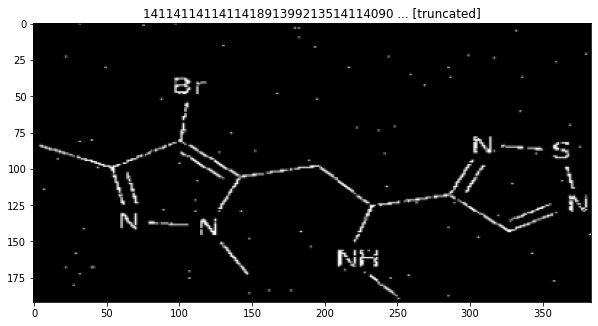


IMAGE SHAPE : (192, 384, 3)
IMAGE INCHI : ['141', '141', '141', '141', '140', '87', '134', '87', '90', '133', '137', '132']



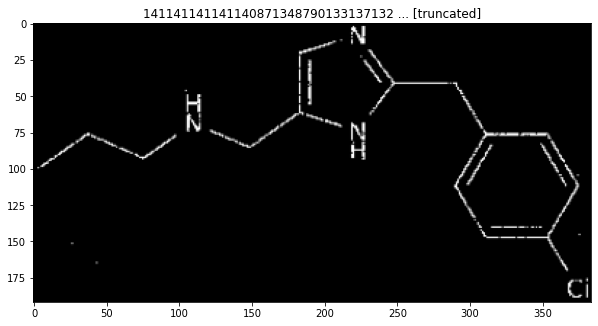


... DECODING RAW TFRECORD DATASETS COMPLETED ...



In [18]:
print("\n... DECODING RAW TFRECORD DATASETS STARTING ...\n")

# Decode the tfrecords completely –– decode is our `_parse_function` (from recipe above)
test_ds = raw_test_ds.map(lambda x: decode(x, is_test=True))


print("\n... 2 EXAMPLES OF IMAGES AND LABELS AFTER DECODING ...")
for i, (img, inchi) in enumerate(test_ds.take(2)):
    print(f"\nIMAGE SHAPE : {img.shape}")
    print(f"IMAGE INCHI : {[int_2_tok[x] for x in inchi.numpy()]}\n")
    plt.figure(figsize=(10,10))
    plt.imshow(img.numpy().astype(np.int64), cmap="gray")
    plt.title(f"{''.join([int_2_tok[x] for x in inchi.numpy() if x!=0][:50])} ... [truncated]")
    plt.show()

print("\n... DECODING RAW TFRECORD DATASETS COMPLETED ...\n")

In [19]:
def load_dataset(filenames, is_test=False, ordered=False, tokenized_inchi=True):
    """Read from TFRecords.
    
    For optimal performance, reading from multiple files at once and disregarding data order (if `ordered=False`).
        - If pulling InChI from TFRecords than order does not matter since we will 
          be shuffling the data anyway (for training dataset).
          
    Args:
        filenames (list of strings): List of paths to that point to the respective TFRecord files
        is_test (bool, optional): Whether or not to include the image ID or label in the returned dataset
        ordered (bool, optional): Whether to ensured ordered results or maximize parallelization
        tokenized_inchi (bool, optional): Whether our dataset includes the tokenized inchi or we will be 
            creating it from the caption numpy array
        
    Returns:
        Decoded tf.data.Dataset object
    """

    options = tf.data.Options()
    if not ordered:
        # disable order, increase speed
        options.experimental_deterministic = False
        N_PARALLEL=tf.data.AUTOTUNE
    else:
        N_PARALLEL=None
        
    # If not-ordered, this will read in by automatically interleaving multiple tfrecord files.
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=N_PARALLEL)
    
    # If not-ordered, this will ensure that we use data as soon as it 
    # streams in, rather than in its original order.
    dataset = dataset.with_options(options) 
    
    # parse and return a dataset w/ the appropriate configuration
    dataset = dataset.map(
        lambda x: decode(x, is_test, tokenized_inchi),
        num_parallel_calls=N_PARALLEL,
    )
    
    return dataset

def get_dataset(filenames, batch_size, 
                is_test=False, 
                shuffle_buffer_size=1, 
                repeat_dataset=True, 
                preserve_file_order=False, 
                drop_remainder=True,
                tokenized_inchi=True,
                external_inchi_dataset=None,
                augment=False,
                test_padding=0):
    """ Get a tf.data.Dataset w/ the appropriate configuration
    
    Args:
        TBD
        test_padding (int, optional): Amount required to pad dataset to have only full batches
        
    Returns:
        TBD
        
    """
    # Load the dataset
    dataset = load_dataset(filenames, is_test, preserve_file_order, tokenized_inchi)
    
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    if test_padding!=0:
        pad_dataset = tf.data.Dataset.from_tensor_slices((
            tf.zeros((test_padding, *IMG_SHAPE), dtype=TARGET_DTYPE),       # Fake Images
            tf.constant(["000000000000",]*test_padding, dtype=tf.string))   # Fake IDs
        )
        dataset = dataset.concatenate(pad_dataset)
    
    # If we are training than we will want to repeat the dataset. 
    # We will determine the number of steps (or updates) later for 1 training epoch.
    if repeat_dataset:
        dataset = dataset.repeat()
    
    # If we need to add on manually the inchi
    if external_inchi_dataset is not None:
        # Zip the datasets and tile the 1 channel image to 3 channels & drop the old inchi value
        dataset = tf.data.Dataset.zip((dataset, external_inchi_dataset))
        dataset = dataset.map(lambda x,y: (tf.tile(tf.expand_dims(x[0], -1), tf.constant([1,1,3], tf.int32)), y))
                              
    # Shuffling
    if shuffle_buffer_size!=1:
        dataset = dataset.shuffle(shuffle_buffer_size)
    
    # Batching
    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    
    # prefetch next batch while training (autotune prefetch buffer size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

In [20]:
####### ####### ####### ####### ####### ####### ####### #######

# Template Configuration
DS_TEMPLATE_CONFIG = dict(
    filenames=[],
    batch_size=1,
    is_test=False, 
    shuffle_buffer_size=1, 
    repeat_dataset=True, 
    preserve_file_order=False, 
    drop_remainder=True,
    tokenized_inchi=True,
    external_inchi_dataset=None,
    augment=False,
    test_padding=0
)

####### ####### ####### ####### ####### ####### ####### #######

# Individual Respective Configurations

TEST_DS_CONFIG = DS_TEMPLATE_CONFIG.copy()
TEST_DS_CONFIG.update(dict(
    filenames=TEST_TFREC_PATHS,
    batch_size=OVERALL_BATCH_SIZE,
    is_test=True,
    repeat_dataset=False,
    drop_remainder=False,
    test_padding=REQUIRED_DATASET_PAD,
    augment=False
))

####### ####### ####### ####### ####### ####### ####### #######

test_ds = get_dataset(**TEST_DS_CONFIG)

for SPLIT, CONFIG in zip(["TESTING"], [TEST_DS_CONFIG]): # , TEST_DS_CONFIG]
    print(f"\n... {SPLIT} CONFIGURATION:")
    for k,v in CONFIG.items():
        if k=="filenames":
            print(f"\t--> {k:<23}: {[path.split('/', 4)[-1] for path in v[:2]]+['...']}")
        else:
            print(f"\t--> {k:<23}: {v}")

print(f"... TESTING DATASET    : {test_ds}    ...\n")


... TESTING CONFIGURATION:
	--> filenames              : ['records_01_41.tfrec', 'records_02_41.tfrec', '...']
	--> batch_size             : 512
	--> is_test                : True
	--> shuffle_buffer_size    : 1
	--> repeat_dataset         : False
	--> preserve_file_order    : False
	--> drop_remainder         : False
	--> tokenized_inchi        : True
	--> external_inchi_dataset : None
	--> augment                : False
	--> test_padding           : 277
... TESTING DATASET    : <PrefetchDataset shapes: ((None, 192, 384, 3), (None,)), types: (tf.bfloat16, tf.string)>    ...



In [21]:
# Will yield, at the lowest feature level, (6,12,208) or (72,208)
def get_efficientnetv2_backbone(model_name, include_top=False, input_shape=(192,384,3), pooling=None, weights=None, weights_path=None):
    backbone = effnetv2_model.EffNetV2Model(model_name=model_name)    
    backbone(tf.ones((BATCH_SIZE_DEBUG,*input_shape)), training=False, features_only=True)
    
    if weights:
        print(f'.. Loading pretrained {model_name} checkpoint')
        ckpt = tf.train.latest_checkpoint(weights_path)
        backbone.load_weights(ckpt)

    return backbone

In [22]:
print("\n... ENCODER MODEL CREATION STARTING ...\n")

# SAMPLE IMAGES
SAMPLE_IMGS, SAMPLE_LBLS = next(iter(test_ds.unbatch().batch(BATCH_SIZE_DEBUG)))

# ENCODER_CONFIG
PREPROCESSING_FN = tf.keras.applications.efficientnet.preprocess_input
BB_FN = get_efficientnetv2_backbone

# This will be the dimension the network outputs flattened
IMG_EMB_DIM = (6,12,232)
#IMG_EMB_DIM = (8,14,232)
print(f"\n... RAW BB OUTPUT: {IMG_EMB_DIM} ...\n")
IMG_EMB_DIM = (IMG_EMB_DIM[0]*IMG_EMB_DIM[1], IMG_EMB_DIM[2])

class Encoder(tf.keras.Model):
    def __init__(self, image_embedding_dim, preprocessing_fn, backbone_fn, image_shape, do_permute=False, include_top=False, pretrained_weights=None, pretrained_path=None, scale_factor=0):
        super(Encoder, self).__init__()
        
        self.image_embedding_dim = image_embedding_dim
        self.preprocessing_fn = preprocessing_fn
        self.encoder_backbone = backbone_fn(model_name=EV2_NAME, include_top=include_top, weights=pretrained_weights, weights_path=pretrained_path, input_shape=image_shape)        
        self.reshape = tf.keras.layers.Reshape(self.image_embedding_dim, name='image_embedding')
        self.permute = tf.keras.layers.Permute([2, 1], name='permute_features')
        self.do_permute = do_permute
        self.include_top = include_top
        self.scale_factor = scale_factor
        
    def call(self, x, training):
        x = self.preprocessing_fn(x)
        x = self.encoder_backbone(x, training=training, features_only=not self.include_top)[self.scale_factor]
        x = self.reshape(x, training=training)
        if self.do_permute:
            x = self.permute(x, training=training)
        return x
    
# #Example enoder output
# with tf.device('/CPU:0'):
#     encoder = Encoder(IMG_EMB_DIM, PREPROCESSING_FN, BB_FN, IMG_SHAPE, do_permute=IMG_EMB_DIM[1]<IMG_EMB_DIM[0], pretrained_weights=False, pretrained_path=f'../input/efficientnetv2-tf-checkpoints/{EV2_NAME}/')
#     img_embedding_batch = encoder(SAMPLE_IMGS)
# print(f'\n... Encoder Output Shape  :  (batch_size, embedding_length, embedding_depth)  :  {img_embedding_batch.shape} ...\n')

# print("\n... ENCODER MODEL CREATION FINISHED ...\n")


... ENCODER MODEL CREATION STARTING ...


... RAW BB OUTPUT: (6, 12, 232) ...



In [23]:
print("\n... ATTENTION MECHANISM LAYER CREATION STARTING ...\n")
# TO BE REPLACED W/ --> tfa.seq2seq.BahdanauAttention
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, attn_emb_depth):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(attn_emb_depth)
        self.W2 = tf.keras.layers.Dense(attn_emb_depth)
        self.V = tf.keras.layers.Dense(1)

    def call(self, hidden, features, training):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # features shape == (batch_size, img_emb_size, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, img_emb_size, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # img_emb_size refers to the product of the image embedding width and height (144 for EB)
        # the shape of the tensor before applying self.V is (batch_size, img_emb_size, attention_emb_depth)
        score = self.V(
            tf.nn.tanh(self.W1(hidden_with_time_axis, training=training) + \
                       self.W2(features, training=training)), 
            training=training
        )

        # attention_weights shape (before & after) == (batch_size, img_emb_size, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after multiplication is (batch_size, img_emb_size, 1)
        context_vector = attention_weights * features
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1) # this is axis 2 in some implementations?
        
        return context_vector, attention_weights
    
    
# ATTN_EMB_DIM  = 512
# # N_RNN_UNITS   = 1024
# with tf.device('/CPU:0'):
#     attn_layer = BahdanauAttention(ATTN_EMB_DIM)
#     context_vector, attn_weights = attn_layer(tf.zeros([BATCH_SIZE_DEBUG, IMG_EMB_DIM[0]]), img_embedding_batch)

# print(f'\n... Context Vector Shape     :  (batch_size, img_emb_dim_depth)     :  {context_vector.shape}   ...')
# print(f'... Attention Weights Shape  :  (batch_size, img_emb_dim_shape, 1)  :  {attn_weights.shape} ...\n')

# print("\n... ATTENTION MECHANISM LAYER CREATION FINISHED ...\n")


... ATTENTION MECHANISM LAYER CREATION STARTING ...



In [24]:
print("\n... DECODER MODEL CREATION STARTING ...\n")

class Decoder(tf.keras.Model):
    def __init__(self, vocab_len, attn_emb_depth, img_emb_dim, n_rnn_units, dropout_rate=0.25):
        super(Decoder, self).__init__()
        
        # Basic Parameters
        self.vocab_len = vocab_len
        self.attn_emb_depth = attn_emb_depth
        self.img_emb_dim = img_emb_dim
        self.n_rnn_units = n_rnn_units
        self.dropout_rate = dropout_rate
        
        # Attention Mechanism
        self.attention_layer = BahdanauAttention(self.attn_emb_depth)
        
        # LSTM hidden and carry state initialization
        self.init_h_layer = tf.keras.layers.Dense(
            units=n_rnn_units, input_shape=[img_emb_dim], name='img_embedding__hidden_init_layer'
        )
        self.init_c_layer = tf.keras.layers.Dense(
            units=n_rnn_units, input_shape=[img_emb_dim], name='img_embedding__input_act_init_layer'
        )
        
        # Character Embedding Layer In The Decoder
        #    - TODO ... `mask_zero=True` ???
        self.embedding_layer = tf.keras.layers.Embedding(vocab_len, n_rnn_units, )
        
        # The LSTM cell
        self.lstm_cell_layer = tf.keras.layers.LSTMCell(n_rnn_units, name='lstm_cell_layer')
        
        # Dropout Layer to Prevent Overfitting
        self.dropout_layer = tf.keras.layers.Dropout(self.dropout_rate, name='dropout_layer')
        
        # Fully Connected Prediction Layer 
        self.fcn_layer = tf.keras.layers.Dense(units=vocab_len, input_shape=[n_rnn_units], dtype=tf.float32, name='fc_prediction_layer')

    def call(self, token, hidden, memory, img_emb, training):
        # img_emb shape == (batch_size, img_emb_shape, hidden_size)
        #    --> We ignore the attention weights for now (_)
        context_vector, _ = self.attention_layer(hidden, img_emb, training=training)

        # shape after passing token through embedding == (batch_size, 1, n_rnn_units)
        # shape after passing through squeeze == (batch_size, n_rnn_units)
        tok_emb = tf.squeeze(self.embedding_layer(token, training=training), axis=1)
        
        # shape after concatenation == (batch_size, n_rnn_units + hidden_size)
        x = tf.concat((context_vector, tok_emb), axis=-1)

        # passing the concatenated vector to the LSTM cell
        #    - also getting the new hidden (h) and memory (c) vectors
        _, (hidden_new, memory_new) = self.lstm_cell_layer(x, (hidden, memory), training=training)
        
        #### ##### ##### ####
        # MORE LSTM LAYERS? #
        #### ##### ##### ####
        
       # compute prediction logits and leverage dropout
        output = self.dropout_layer(hidden_new, training=training)
        output = self.fcn_layer(output, training=training)

        return output, hidden_new, memory_new
    
    def init_hidden_state(self, img_emb, training):
        mean_encoder_out = tf.math.reduce_mean(img_emb, axis=1)
        hidden = self.init_h_layer(mean_encoder_out, training=training)  # (batch_size, n_rnn_units)
        memory = self.init_c_layer(mean_encoder_out, training=training)
        return hidden, memory


# with tf.device('/CPU:0'):
#     decoder = Decoder(VOCAB_LEN, ATTN_EMB_DIM, IMG_EMB_DIM[0], N_RNN_UNITS)
#     h, c = decoder.init_hidden_state(img_embedding_batch[:BATCH_SIZE_DEBUG], training=False)
#     pred_output, h, c = decoder(tf.random.uniform((BATCH_SIZE_DEBUG, 1)), h, c, img_embedding_batch)

# print(f'\n... Decoder Output Shape  :  (batch_size, vocab_len)  :  {pred_output.shape} ...\n')

# print("\n... DECODER MODEL CREATION FINISHED ...\n")


... DECODER MODEL CREATION STARTING ...



In [25]:
class Config():
    def __init__(self,):
        self.encoder_config = {}
        self.decoder_config = {}
        self.lr_config = {}
    def initialize_encoder_config(self, image_embedding_dim, preprocessing_fn, backbone_fn, image_shape, do_permute=False, pretrained_weights=False, pretrained_path=f'{GCS_CHECKPOINT_PATH}/{EV2_NAME}/'):
        self.encoder_config = dict(
            image_embedding_dim=image_embedding_dim, 
            preprocessing_fn=preprocessing_fn, 
            backbone_fn=backbone_fn, 
            image_shape=image_shape, 
            do_permute=do_permute, 
            pretrained_weights=pretrained_weights,
            pretrained_path=pretrained_path,
        )
    def initialize_decoder_config(self, vocab_len, attn_emb_depth, img_emb_dim, n_rnn_units, dropout_rate=0.15):
        self.decoder_config = dict(
            vocab_len=vocab_len, 
            attn_emb_depth=attn_emb_depth, 
            img_emb_dim=img_emb_dim, 
            n_rnn_units=n_rnn_units, 
            dropout_rate=dropout_rate,
        )
        
training_config = Config()
training_config.initialize_encoder_config(image_embedding_dim=IMG_EMB_DIM, 
                                          preprocessing_fn=PREPROCESSING_FN, 
                                          backbone_fn=BB_FN, 
                                          image_shape=IMG_SHAPE, 
                                          do_permute=IMG_EMB_DIM[1]<IMG_EMB_DIM[0])
training_config.initialize_decoder_config(vocab_len=VOCAB_LEN, 
                                          attn_emb_depth=ATTN_EMB_DIM, 
                                          img_emb_dim=IMG_EMB_DIM[0], 
                                          n_rnn_units=N_RNN_UNITS)


print(f"\nTRAINING ENCODER CONFIG:\n\t--> {training_config.encoder_config}\n")
print(f"TRAINING DECODER CONFIG:\n\t--> {training_config.decoder_config}\n")



TRAINING ENCODER CONFIG:
	--> {'image_embedding_dim': (72, 232), 'preprocessing_fn': <function preprocess_input at 0x7feb12f804d0>, 'backbone_fn': <function get_efficientnetv2_backbone at 0x7feacc54b290>, 'image_shape': (192, 384, 3), 'do_permute': False, 'pretrained_weights': False, 'pretrained_path': 'gs://kds-fe38ac61cd34692e7b56b9ad4fcc2fa1467d59671e9d235923de17d8/efficientnetv2-b3/'}

TRAINING DECODER CONFIG:
	--> {'vocab_len': 197, 'attn_emb_depth': 192, 'img_emb_dim': 72, 'n_rnn_units': 512, 'dropout_rate': 0.15}



In [26]:
print("\n... TESTING PREPERATION STARTING ...\n")

def prepare_for_training(encoder_config, decoder_config, encoder_wts=None, decoder_wts=None, verbose=0):
    """ Declare required objects under TPU session scope and return ready for training
    
    Args:
        lr_config (dict): Keyword arguments mapped to desired values for lr schedule function
        encoder_config (dict): Keyword arguments mapped to desired values for encoder model instantiation
        decoder_config (dict): Keyword arguments mapped to desired values for decoder model instantiation    
        encoder_wts (str, optional): Path to pretrained model weights for encoder
        decoder_wts (str, optional): Path to pretrained model weights for decoder
        verbose (bool, optional): Whether or not to print model information and plot lr schedule
        
    Returns:
        loss_fn - TBD
        metrics - TBD
        optimizer - TBD
        lr_scheduler - TBD
        encoder - TBD
        decoder - TBD
        
    """
    

    # Everything must be declared within the scope when leveraging the TPU strategy
    #     - This will still function properly if scope is set to another type of accelerator
    with strategy.scope():
        
        
        # Instantiate the encoder model 
        print("\t--> CREATING ENCODER1 MODEL ARCHITECTURE ...")
        encoder_1 = Encoder(**encoder_config)
        initialization_batch_1 = encoder_1(
            tf.ones(((REPLICA_BATCH_SIZE,)+encoder_config["image_shape"]), dtype=TARGET_DTYPE), 
            training=False,
        )
        
        print("\t--> CREATING ENCODER2 MODEL ARCHITECTURE ...")
        encoder_2 = Encoder(**encoder_config)
        initialization_batch_2 = encoder_2(
            tf.ones(((REPLICA_BATCH_SIZE,)+encoder_config["image_shape"]), dtype=TARGET_DTYPE), 
            training=False,
        )
        
        print("\t--> CREATING ENCODER3 MODEL ARCHITECTURE ...")
        encoder_3 = Encoder(**encoder_config)
        initialization_batch_3 = encoder_3(
            tf.ones(((REPLICA_BATCH_SIZE,)+encoder_config["image_shape"]), dtype=TARGET_DTYPE), 
            training=False,
        )
        
        # Instantiate the decoder model
        print("\t--> CREATING DECODER1 MODEL ARCHITECTURE...")
        decoder_1 = Decoder(**decoder_config)
        init_h_1, init_c_1 = decoder_1.init_hidden_state(initialization_batch_1[:REPLICA_BATCH_SIZE], training=False)
        pred_output_1, h_1, c_1 = decoder_1(
            tf.random.uniform((REPLICA_BATCH_SIZE, 1)), 
            init_h_1, init_c_1, initialization_batch_1, 
            training=False,
        )
        
        print("\t--> CREATING DECODER2 MODEL ARCHITECTURE...")
        decoder_2 = Decoder(**decoder_config)
        init_h_2, init_c_2 = decoder_2.init_hidden_state(initialization_batch_2[:REPLICA_BATCH_SIZE], training=False)
        pred_output_2, h_2, c_2 = decoder_2(
            tf.random.uniform((REPLICA_BATCH_SIZE, 1)), 
            init_h_2, init_c_2, initialization_batch_2, 
            training=False,
        )
        
        print("\t--> CREATING DECODER3 MODEL ARCHITECTURE...")
        decoder_3 = Decoder(**decoder_config)
        init_h_3, init_c_3 = decoder_3.init_hidden_state(initialization_batch_3[:REPLICA_BATCH_SIZE], training=False)
        pred_output_3, h_3, c_3 = decoder_3(
            tf.random.uniform((REPLICA_BATCH_SIZE, 1)), 
            init_h_3, init_c_3, initialization_batch_3, 
            training=False,
        )
        
        # Load weights after variable initialization
        if encoder_wts is not None:
            print("\t--> LOADING ENCODER MODEL WEIGHTS ...")
            encoder.load_weights(encoder_wts)
        if decoder_wts is not None:
            print("\t--> LOADING DECODER MODEL WEIGHTS ...")
            decoder.load_weights(decoder_wts)
        
    # Show the model architectures and plot the learning rate
    if verbose:
        print("\n\n... ENCODER1 MODEL SUMMARY...\n")
        print(encoder_1.summary())
        
        print("\n\n... ENCODER2 MODEL SUMMARY...\n")
        print(encoder_2.summary())
        
        print("\n\n... ENCODER3 MODEL SUMMARY...\n")
        print(encoder_3.summary())

        print("\n\n... DECODER1 MODEL SUMMARY...\n")
        print(decoder_1.summary())
        
        print("\n\n... DECODER2 MODEL SUMMARY...\n")
        print(decoder_2.summary())
        
        print("\n\n... DECODER3 MODEL SUMMARY...\n")
        print(decoder_3.summary())

  
    return encoder_1, encoder_2, encoder_3, decoder_1, decoder_2, decoder_3
    
    
print("\n... GENERATING THE FOLLOWING:")
# Instantiate our required training components in the correct scope
encoder_1, encoder_2, encoder_3, decoder_1, decoder_2, decoder_3 = \
    prepare_for_training(encoder_config=training_config.encoder_config,
                         decoder_config=training_config.decoder_config,
                         encoder_wts=(ENCODER_CKPT_PATH if ENCODER_CKPT_PATH!="" else None),
                         decoder_wts=(DECODER_CKPT_PATH if DECODER_CKPT_PATH!="" else None),
                         verbose=0,)

print("\n... TRAINING PREPERATION FINISHED ...\n")


... TESTING PREPERATION STARTING ...


... GENERATING THE FOLLOWING:
	--> CREATING ENCODER1 MODEL ARCHITECTURE ...
	--> CREATING ENCODER2 MODEL ARCHITECTURE ...
	--> CREATING ENCODER3 MODEL ARCHITECTURE ...
	--> CREATING DECODER1 MODEL ARCHITECTURE...
	--> CREATING DECODER2 MODEL ARCHITECTURE...
	--> CREATING DECODER3 MODEL ARCHITECTURE...

... TRAINING PREPERATION FINISHED ...



In [27]:
encoder_1.load_weights(f'../input/bms-tpu-ensemble-models/encoder_epoch_2.82.h5')
decoder_1.load_weights(f'../input/bms-tpu-ensemble-models/decoder_epoch_2.82.h5')

encoder_2.load_weights(f'../input/bms-tpu-ensemble-models/encoder_epoch_2.86.h5')
decoder_2.load_weights(f'../input/bms-tpu-ensemble-models/decoder_epoch_2.86.h5')

encoder_3.load_weights(f'../input/bms-tpu-ensemble-models/encoder_epoch_2.77.h5')
decoder_3.load_weights(f'../input/bms-tpu-ensemble-models/decoder_epoch_2.77.h5')

In [28]:
def test_step(_image_batch):
    """ Forward pass (calculate gradients)
    
    Args:
        image_batch (): TBD
        inchi_batch (): TBD
    
    Returns:
        tbd
    """
    
    # image_batch_embedding has shape --> (REPLICA_BATCH_SIZE, IMG_EMB_DIM)
    image_batch_embedding_1 = encoder_1(_image_batch, training=False)
    image_batch_embedding_2 = encoder_2(_image_batch, training=False)
    image_batch_embedding_3 = encoder_3(_image_batch, training=False)

    # hidden and memory both have the shape --> (REPLICA_BATCH_SIZE, N_RNN_UNITS)
    hidden_batch_1, memory_batch_1 = decoder_1.init_hidden_state(image_batch_embedding_1, training=False)
    hidden_batch_2, memory_batch_2 = decoder_2.init_hidden_state(image_batch_embedding_2, training=False)
    hidden_batch_3, memory_batch_3 = decoder_3.init_hidden_state(image_batch_embedding_3, training=False)

    # decoder_input and predictions_seq share the shape --> (REPLICA_BATCH_SIZE, 1)
    decoder_input_batch = tf.ones((REPLICA_BATCH_SIZE, 1), dtype=tf.uint8)
    predictions_seq_batch = tf.ones((REPLICA_BATCH_SIZE, 1), dtype=tf.uint8)

    # Teacher forcing - feeding the target as the next input
    for c_idx in range(1, MAX_LEN):
        
        #### model 1 #####
        # passing enc_output to decoder1
        prediction_batch_1, hidden_batch_1, memory_batch_1 = \
            decoder_1(decoder_input_batch, hidden_batch_1, memory_batch_1, image_batch_embedding_1, training=False)
        
        #### model 2 #####
        # passing enc_output to decoder2
        prediction_batch_2, hidden_batch_2, memory_batch_2 = \
            decoder_2(decoder_input_batch, hidden_batch_2, memory_batch_2, image_batch_embedding_2, training=False)
        
        #### model 3 #####
        # passing enc_output to decoder3
        prediction_batch_3, hidden_batch_3, memory_batch_3 = \
            decoder_3(decoder_input_batch, hidden_batch_3, memory_batch_3, image_batch_embedding_3, training=False)
        
        #prediction_batch = (prediction_batch_1 + prediction_batch_2 + prediction_batch_3) / 3.0
        prediction_batch = (prediction_batch_1 * 0.25) + (prediction_batch_2 * 0.35) + (prediction_batch_3 * 0.40)

        # no teacher forcing, predicted char is next LSTMCell input
        decoder_input_batch = tf.cast(tf.expand_dims(tf.math.argmax(prediction_batch, axis=1, output_type=tf.int32), axis=1), tf.uint8)
        
        # Build the prediction sequence
        predictions_seq_batch = tf.concat([predictions_seq_batch, decoder_input_batch], axis=1)
    
    return predictions_seq_batch  

    
@tf.function
def distributed_test_step(_img_batch, _img_ids):
    per_replica_seqs = strategy.run(test_step, args=(_img_batch,))
    predictions = strategy.gather(per_replica_seqs, axis=0)
    pred_ids = strategy.gather(_img_ids, axis=0)
    return predictions, pred_ids

In [29]:
# To Store The Preds
all_pred_arr = tf.zeros((1, MAX_LEN), dtype=tf.uint8)
all_pred_ids = tf.zeros((1, 1), dtype=tf.string)

# Create an iterator
dist_test_ds = iter(strategy.experimental_distribute_dataset(test_ds))
for i in tqdm(range(TEST_STEPS), total=TEST_STEPS): 
    img_batch, id_batch = next(dist_test_ds)
    preds, pred_ids = distributed_test_step(img_batch, id_batch)
    all_pred_arr = tf.concat([all_pred_arr, preds], axis=0)
    all_pred_ids = tf.concat([all_pred_ids, tf.expand_dims(pred_ids, axis=-1)], axis=0)

  0%|          | 0/3157 [00:00<?, ?it/s]

In [30]:
def arr_2_inchi(arr):
    inchi_str = ''
    for i in arr:
        c = int_2_tok.get(i)
        if c=="<END>":
            break
        inchi_str += c
    return inchi_str

pred_df = pd.DataFrame({
    "image_id":[x[0].decode() for x in tqdm(all_pred_ids[1:-REQUIRED_DATASET_PAD].numpy(), total=N_TEST)], 
    "InChI":[arr_2_inchi(pred_arr) for pred_arr in tqdm(all_pred_arr[1:-REQUIRED_DATASET_PAD].numpy(), total=N_TEST)]
})

pred_df = pred_df.sort_values(by="image_id").reset_index(drop=True)
pred_df

  0%|          | 0/1616107 [00:00<?, ?it/s]

  0%|          | 0/1616107 [00:00<?, ?it/s]

,image_id,InChI
0,00000d2a601c,InChI=1S/C10H14BrN5S/c1-6-10(11)9(16(3)14-6)4-...
1,00001f7fc849,InChI=1S/C14H18ClN3/c1-2-7-16-9-13-10-17-14(18...
2,000037687605,InChI=1S/C16H13BrN2O/c1-11(20)12-6-7-13(9-18)1...
3,00004b6d55b6,"InChI=1S/C14H19FN4O/c1-14(2,3)12-13(16)17-18-1..."
4,00004df0fe53,InChI=1S/C9H12O2/c1-4-5-2-6-7(3-5)11-9(10)8(4)...
...,...,...
1616102,ffffcdb2e39e,InChI=1S/C21H28N2O2/c1-15(2)14-25-19-10-8-17(9...
1616103,ffffcfddd770,InChI=1S/C24H28N2O5/c1-5-30-19-9-8-17(13-16(19...
1616104,ffffe4ab06b2,InChI=1S/C17H17NO3/c19-12-6-7-14-13(10-12)16-1...
1616105,ffffec4033ec,"InChI=1S/C12H14F3NO3S/c1-2-3-4-9-16-20(17,18)1..."


In [31]:
pred_df.to_csv("submission.csv", index=False)